In [ ]:
import networkx as nx
import numpy as np
from nx_landmarks import landmarks, selection_strategies
from tqdm import tqdm

In [2]:
G = nx.read_adjlist('Data/com-dblp_ungraph.csv')
G = nx.convert_node_labels_to_integers(G)

In [ ]:
precomputed = {
    'rand':selection_strategies.random_ranking(G),
    'deg':selection_strategies.degree_ranking(G),
    'close':selection_strategies.closeness_ranking(G, k = 500),
    'between':selection_strategies.betweenness_ranking(G, k = 500),
}
precomputed['iteritave'] = selection_strategies.iterative_sampling(G, ranking=precomputed['between'])

In [ ]:
landmarks_arr = [
    landmarks(G,10,['rand'],1, precomputed=precomputed),
    landmarks(G,10, [('deg',(1/3)), ('close',(1/3)), ('between',(1/3))],1, precomputed=precomputed),
    landmarks(G,10, [('close',(1/2)), ('between',(1/2))],1, precomputed=precomputed),
    landmarks(G,10,['deg'],1, precomputed=precomputed),
    landmarks(G,10,['close'],1, precomputed=precomputed),
    landmarks(G,10,['between'],1, precomputed=precomputed),
    landmarks(G,10,['iteritave'],1, precomputed=precomputed)
]
for D in landmarks_arr:
    D.get_landmarks()


Done...


In [ ]:
def sample_random_pairs(G,n = 1):
    choice = np.random.choice(G.nodes(),2*n,replace = False)
    pairs =[]
    for i in range(n):
        idx = 2*i
        pairs.append(((choice[idx]),choice[idx+1]))
    return pairs

def average_error(D,pairs,true = None):
    if true == None:
        true = [nx.shortest_path_length(G, source=s,target=t) for s,t in pairs]
    estimations = []
    for pair in pairs:
        estimations.append(D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    errors = [(e-t)/t for e,t in zip(estimations,true)]
    return sum(errors)/len(errors)

def LU_ratio_dist(D,pairs):
    ratio = []
    for pair in pairs:
        ratio.append(D.shortest_path_estimation_lower_bound(pair[0],pair[1])/D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    return ratio

In [ ]:
def experiment_setup(G,landmarks:list)->list:
    
    results_rel_error = [[] for D in landmarks]
    results_lu_ratio = [[] for D in landmarks]
    
    for n_landm in tqdm(range(10,500,10)):
        for idx,D in enumerate(landmarks):
            result_err = []
            result_lu = []
            for i in range(10):
                result_err.append((average_error(D,sample_random_pairs(G,2000))))
                if len(D.landmarks) == 20 or len(D.landmarks) == 100:
                    result_lu.append((LU_ratio_dist(D,sample_random_pairs(G,2000))))
            results_rel_error[idx].append((np.average(np.array(result_err)),len(D.landmarks)))
            results_lu_ratio[idx].append((np.average(np.array(result_lu)),len(D.landmarks)))
            D.add_landmarks(10)
    return results_rel_error,results_lu_ratio

In [38]:
results_rel_error,results_lu_ratio = experiment_setup(G,landmarks_arr)

100%|██████████| 45/45 [37:52<00:00, 50.50s/it]


C:\Users\jaspe\AppData\Local\Temp\ipykernel_21860\117723870.py:26: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0)


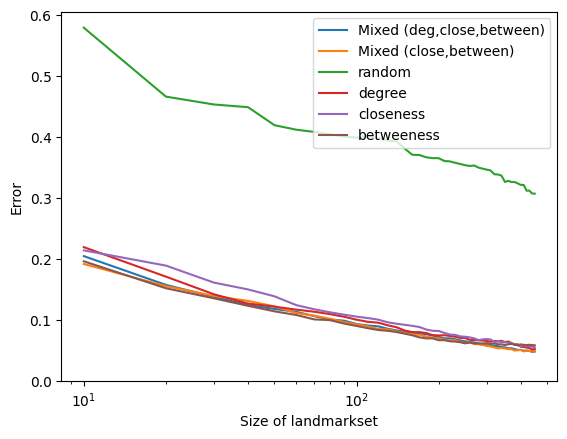

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
x = [a[1] for a in results_rel_error[1]]
y = [a[0] for a in results_rel_error[1]]
ax.plot(x,y, label = 'Mixed (deg,close,between)')
x = [a[1] for a in results_rel_error[2]]
y = [a[0] for a in results_rel_error[2]]
ax.plot(x,y, label = 'Mixed (close,between)')
x = [a[1] for a in results_rel_error[0]]
y = [a[0] for a in results_rel_error[0]]
ax.plot(x,y, label = 'random')
x = [a[1] for a in results_rel_error[3]]
y = [a[0] for a in results_rel_error[3]]
ax.plot(x,y, label = 'degree')
x = [a[1] for a in results_rel_error[4]]
y = [a[0] for a in results_rel_error[4]]
ax.plot(x,y, label = 'closeness')
x = [a[1] for a in results_rel_error[5]]
y = [a[0] for a in results_rel_error[5]]
ax.plot(x,y, label = 'betweeness')
x = [a[1] for a in results_rel_error[6]]
y = [a[0] for a in results_rel_error[6]]
ax.plot(x,y, label = 'iterative')

ax.set_ylabel('Error')
ax.set_xlabel('Size of landmarkset')
ax.set_xscale('log')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(results_rel_error)
df

In [ ]:
good  = 0
bad = 0
found = 0 
for pair in tqdm(sample_random_pairs(G,1000000)):
    s = pair[0]
    t = pair[1]
    pred_upper = D.shortest_path_estimation_upper_bound(source=s, target=t)
    pred_cap = D.shortest_path_estimation_capture_method(source=s,target=t)
    true = nx.shortest_path_length(G,s,t)
    if pred_cap != pred_upper:
        good += abs(pred_cap-true)
        found += 1
        bad += abs(pred_upper-true)

print(f'average error capture: {good/found}\naverage error upper bound: {bad/found}')